In [19]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker

from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

In [128]:
pgroup='p21211'
runnumber = 332

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0332


'/sf/alvra/data/p21211/raw/run0332-timescan_CpRh_3002p8eV/meta/scan.json'

In [129]:
with_TT    = False
Two_diodes = False

reducedir='../Claudio/Reduced_XANES_timescans_test/'
saveflag=True

quantile_corr = 0.6

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

TT = TT_PSEN126

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

LoadTimescansXANES(with_TT, Two_diodes, scan, TT, channel_delay_motor, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0332-timescan_CpRh_3002p8eV
Step 37 of 37: Processing acq0037

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet      501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:PR1_CH1_VAL_GET 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY    501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 3 / 3 -> 0% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 249 pump and 249 unpump shots
90 shots out of 249 survived
Step 37 of 37: Processed acq0037
correlation Diode (all shots) = 0.9956455037126437
------------------------------
Processed 37 out of 37 files


# Plot the run

* [with TT](#TT)
* [without TT](#no_TT)

<a id='TT'></a>
## with TT

NameError: name 'Delays_corr_scan' is not defined

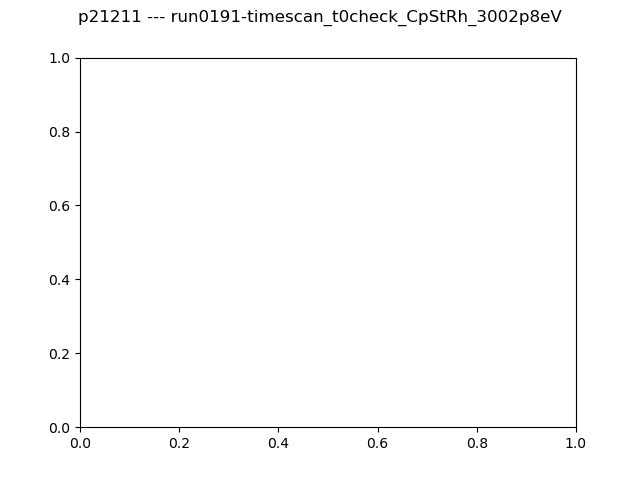

In [319]:
title=""
if Two_diodes:
    Pump_probe_scan  = Pump_probe_scan + Pump_probe_scan2
    Delays_corr_scan = Delays_corr_scan + Delays_corr_scan2
    Delays_fs_scan   = Delays_fs_scan + Delays_fs_scan2
    title = "Two diodes"

plt.figure()
plt.suptitle(titlestring)
plt.title(title)
plt.plot(Delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

### Choose variable binsize...

In [40]:
numbins = 100

#####################################################################################################
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin),
                     np.arange(npt),
                     np.sort(x))

binList = histedges_equalN(Delays_corr_scan, numbins)

bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.copy(bin_centres)

NameError: name 'Delays_corr_scan' is not defined

### ... or a fix binsize with a range

In [20]:
binsize = 10 # in fs

min_delay = -250
max_delay = 1000

#####################################################################################################

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

In [21]:
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr_scan))

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan, Pump_probe_scan, statistic='mean', bins=binList)
pp_std, _, _ = binned_statistic(Delays_fs_scan, Pump_probe_scan, statistic='std', bins=binList)
count = []
for index in range(len(bin_centres)):
    count.append(np.count_nonzero(binNumber == (index+1)))
err_pp = pp_std/np.sqrt(np.array(count))

(10540,) (10540,)


Width = 1.8341 fs


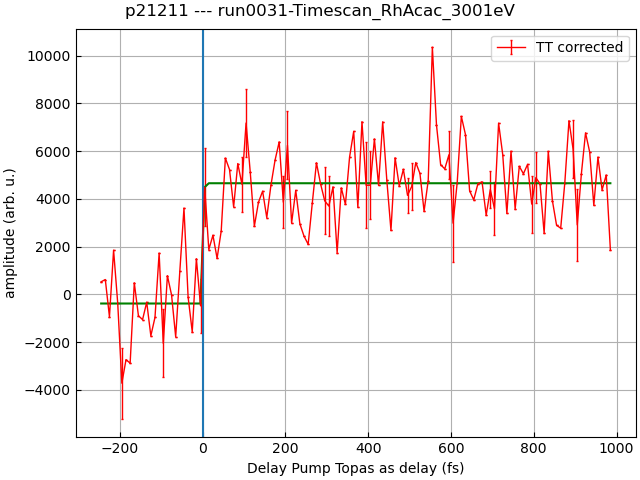

In [22]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle(titlestring)

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

plt.tick_params(direction='in')

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label='TT corrected')

plt.xlabel("{} ({})".format(label, units))
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    #fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    #fit.p0 = better_p0(fit.p0, 4,100)
    fit.p0 = better_p0(fit.p0, 0, 0) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_mm = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs)))

plt.grid()
plt.axvline(0)

plt.show()

<a id='no_TT'></a>
## without TT

Scan is done with the stage in fs


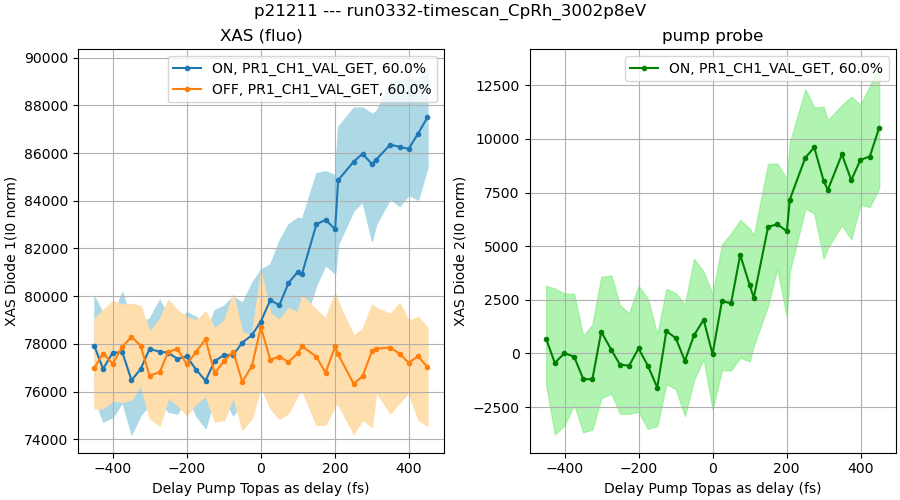

In [130]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Delay_fs = Plot_2diodes_3figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=True)
    Delay_fs, ave_pp1 = Plot_2diodes_Averaged(titlestring, scan, data, timescan=True)
else:
    XAS1_pump_probe, Delay_fs = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=True)

In [91]:
XAS2fit = XAS1_pump_probe
legend = detector_XAS_1
if Two_diodes:
    XAS2fit = ave_pp1
    legend = "Averaged"
    
###################################################

units = scan.parameters['units'][0]
label = scan.parameters['name'][0]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
fit.estimate(Delay_fs, XAS2fit)            # this sets some internal params 
#fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed: 
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 

fit.fit(Delay_fs,XAS2fit)                  # calculate the fit
pp_fit = fit.eval(Delay_fs)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
width_fs = fit.popt[2]

print ("Width = {:.3f} {}".format(abs(width_fs), units))
print ("Position t0 = {:.3f} {}".format(abs(t0_fs), units))

Width = 323.675 fs
Position t0 = 128.197 fs


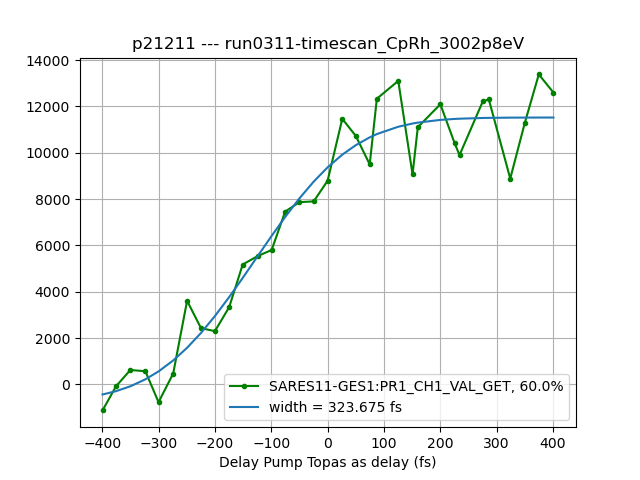

In [92]:
plt.figure()
units = scan.parameters['units'][0]
label = scan.parameters['name'][0]
plt.title(titlestring)
plt.plot(Delay_fs, XAS2fit, label='{}, {}%'.format(legend, quantile_corr*100),color='green',marker='.')
plt.plot(Delay_fs, pp_fit, label = 'width = {:.3f} fs'.format(abs(width_fs)))
plt.legend(loc='best')
plt.xlabel("{} ({})".format(label, units))
plt.grid()
plt.show()